In [1]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch.nn
from tqdm.auto import tqdm
import numpy as np
import os
import pandas as pd
from omegaconf import OmegaConf
from hydra.utils import instantiate
import sys
from datetime import datetime

sys.path.append("..")
import os

/home/vadim/miniconda3/envs/hydra-torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare observations

In [2]:
from src.datamodule.Lorenz96 import L96DataLoader
import hashlib

In [3]:
base_dir = "/home/vadim/Dev/hidden-process-learning"
data_dir = os.path.join(base_dir, "data")
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

# One level model

In [380]:
dt: float = 0.01
f: float = 8
k: int = 40
n_steps: int = 500
spin_up_steps: int = 500
noise_sigma: float = 0.5
part_missing: float = 0.25
seed = 112

In [381]:
pl.seed_everything(seed)

INFO:pytorch_lightning.utilities.seed:Global seed set to 112


112

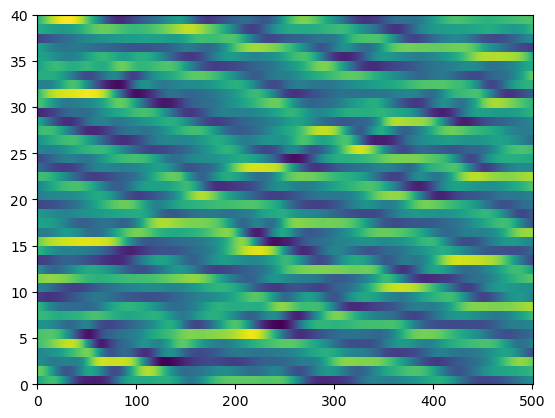

In [382]:
x_true = L96DataLoader.simulate_lorenz96_one_level(dt, k, f, n_steps, spin_up_steps)
plt.pcolor(x_true)

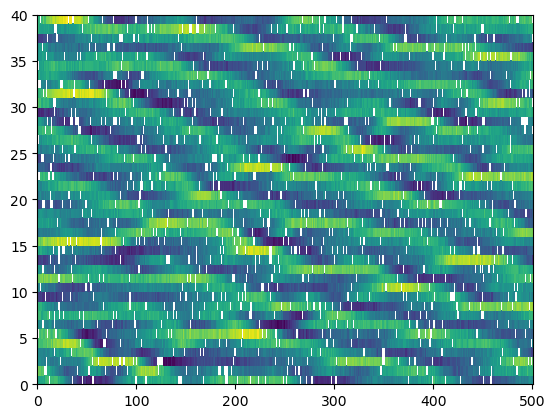

In [383]:
x_obs = L96DataLoader.corrupt_simulation(x_true, noise_sigma, part_missing)
x_obs_preview = x_obs.clone()
x_obs_preview[x_obs_preview == 0] = np.nan
plt.pcolor(x_obs_preview)

In [384]:
data = {
    "x_true": x_true,
    "x_obs": x_obs,
    "params": {
        "f": torch.tensor([f]),
    },
    "meta": {
        "dt": dt,
        "f": f,
        "k": k,
        "n_steps": n_steps,
        "spin_up_steps": spin_up_steps,
        "noise_sigma": noise_sigma,
        "part_missing": part_missing,
        "seed": seed,
    },
}

In [385]:
s = str(sorted(data['meta'].items()))
hash_int = int(hashlib.sha1(s.encode("utf-8")).hexdigest(), 16) % (10 ** 8)
np.save(
    os.path.join(data_dir, f"l96-1-{hash_int}.npy"),
    data,
    allow_pickle=True,
)

# Two levels model

In [192]:
dt: float = 0.01
f: float = 10
b: float = 10
c: float = 1
h: float = 10
k: int = 36
j: int = 10
n_steps: int = 500
spin_up_steps: int = 500
noise_sigma: float = 0.5
part_missing: float = 0.9
seed = 112

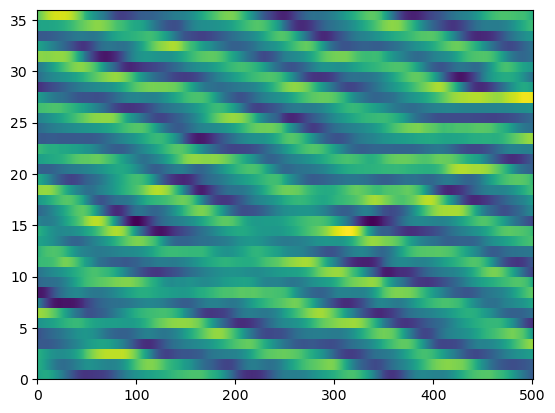

In [193]:
x_true = L96DataLoader.simulate_lorenz96_two_levels(dt, k, j, b, c, f, h, n_steps, spin_up_steps)
plt.pcolor(x_true)

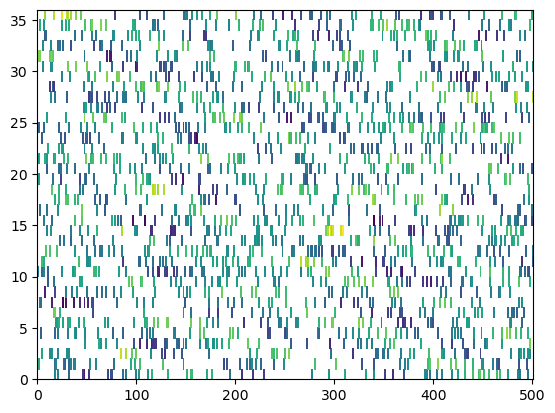

In [194]:
x_obs = L96DataLoader.corrupt_simulation(x_true, noise_sigma, part_missing)
x_obs_preview = x_obs.clone()
x_obs_preview[x_obs_preview == 0] = np.nan
plt.pcolor(x_obs_preview)

In [195]:
data = {
    "x_true": x_true,
    "x_obs": x_obs,
    "params": {
        "f": torch.tensor([f]),
        "b": torch.tensor([b]),
        "c": torch.tensor([c]),
        "h": torch.tensor([h]),
    },
    "meta": {
        "dt": dt,
        "f": f,
        "b": b,
        "c": c,
        "h": h,
        "k": k,
        "j": j,
        "n_steps": n_steps,
        "spin_up_steps": spin_up_steps,
        "noise_sigma": noise_sigma,
        "part_missing": part_missing,
        "seed": seed,
    },
}

In [196]:
s = str(sorted(data['meta'].items()))
hash_int = int(hashlib.sha1(s.encode("utf-8")).hexdigest(), 16) % (10 ** 8)
np.save(
    os.path.join(data_dir, f"l96-2-{hash_int}.npy"),
    data,
    allow_pickle=True,
)

# Run Data Assimilation

In [47]:
from src.datamodule.Lorenz96 import AssimilationDataset
from torch.utils.data import DataLoader

In [48]:
# loading experiment config file
base_path = "/home/vadim/Dev/hidden-process-learning/outputs/outputs/2022-09-15/20-21-57"
config_path = os.path.join(base_path, ".hydra/config.yaml")
cfg = OmegaConf.load(config_path)

In [49]:
# instantiating models
model = instantiate(cfg.model)
assimilator = instantiate(cfg.assimilator)
lit_model = instantiate(cfg.lightning_module, model=model, assimilation_model=assimilator, optimizer=cfg.optimizer)

In [50]:
# loading state dict
state_dict_path = os.path.join(base_path, "logs/checkpoints/epoch=14.ckpt")
state_dict = torch.load(state_dict_path)
lit_model = lit_model.load_from_checkpoint(state_dict_path, model=model, assimilation_model=assimilator, optimizer=cfg.optimizer)

## Run on training and validation data

In [51]:
base_dir = "/home/vadim/Dev/hidden-process-learning"
data_file = "data/l96-1-86287784.npy"
data = np.load(os.path.join(base_dir, data_file), allow_pickle=True).item()
data["meta"]

{'dt': 0.01,
 'f': 8,
 'k': 40,
 'n_steps': 500,
 'spin_up_steps': 500,
 'noise_sigma': 0.5,
 'part_missing': 0.25,
 'seed': 112}

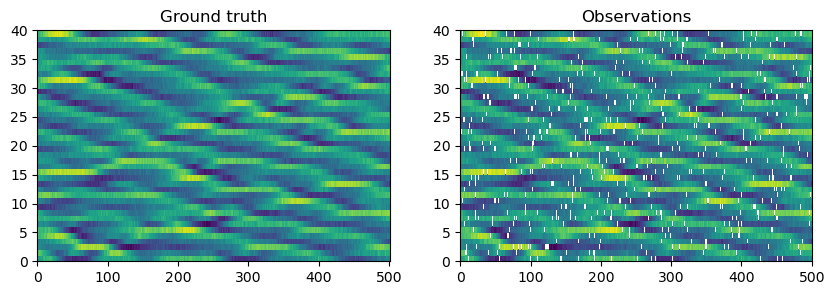

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].set_title("Ground truth")
axs[0].pcolor(data["x_true"])

axs[1].set_title("Observations")
x_obs_preview = data["x_obs"].clone()
x_obs_preview[x_obs_preview == 0] = np.nan
axs[1].pcolor(x_obs_preview)

In [53]:
params = data["params"].copy()
x_obs = data["x_obs"].clone()
dataset = AssimilationDataset(x_obs.unsqueeze(0), params, cfg.datamodule.chunk_size)
dataloader = DataLoader(dataset, batch_size=1)

100%|██████████| 248/248 [00:01<00:00, 235.15it/s]


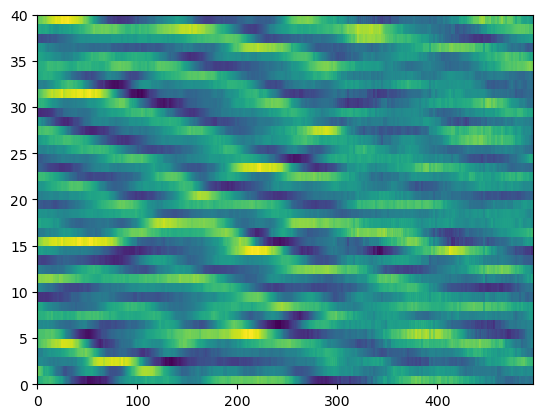

In [54]:
reconstruction = []
for batch in tqdm(dataloader):
    neighbors, _, _, params = batch
    ic_neighbors = neighbors.squeeze()[0]
    ic = assimilator.forward(ic_neighbors)
    rollout = [ic.unsqueeze(0)]
    for i in range(cfg.datamodule.chunk_size - 1):
        x = model.forward(rollout[-1], **params)
        rollout.append(x)
    reconstruction += rollout
reconstruction = torch.stack(reconstruction).squeeze().detach().numpy().T
plt.pcolor(reconstruction)

In [55]:
ground_truth = data["x_true"][..., cfg.datamodule.chunk_size:-cfg.datamodule.chunk_size-1]
observations = x_obs[..., cfg.datamodule.chunk_size:-cfg.datamodule.chunk_size-1]
observations[observations == 0] = np.nan

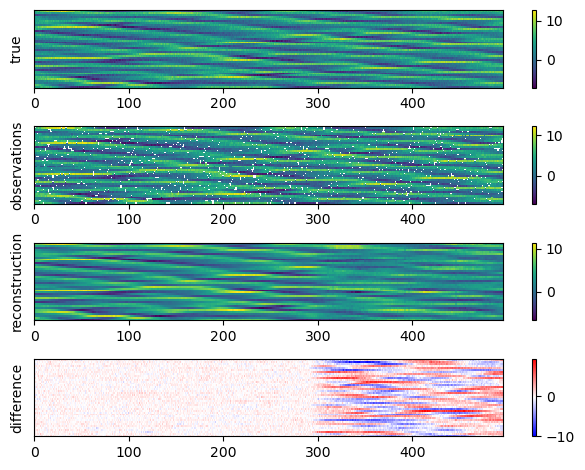

In [56]:
fig, axes = plt.subplots(4, 1, facecolor="w")

axes[0].set_ylabel("true")
img0 = axes[0].pcolor(ground_truth)
plt.colorbar(img0, ax=axes[0])

axes[1].set_ylabel("observations")
img1 = axes[1].pcolor(observations)
plt.colorbar(img1, ax=axes[1])

axes[2].set_ylabel("reconstruction")
img2 = axes[2].pcolor(reconstruction)
plt.colorbar(img2, ax=axes[2])

axes[3].set_ylabel("difference")
img3 = axes[3].pcolor(ground_truth-reconstruction, cmap="bwr")
plt.colorbar(img3, ax=axes[3])

for ax in axes:
    ax.set_yticks([])

plt.tight_layout()

## Run on test data

In [57]:
meta = data["meta"].copy()
meta["spin_up_steps"] += meta["n_steps"]
meta["n_steps"] = 300

seed = meta.pop("seed")
noise_sigma = meta.pop("noise_sigma")
part_missing = meta.pop("part_missing")

In [58]:
params = data["params"].copy()
pl.seed_everything(seed)
if "j" in params.keys():
    x_true = L96DataLoader.simulate_lorenz96_two_levels(**meta)
else:
    x_true = L96DataLoader.simulate_lorenz96_one_level(**meta)
x_obs = L96DataLoader.corrupt_simulation(x_true, noise_sigma, part_missing)

Global seed set to 112


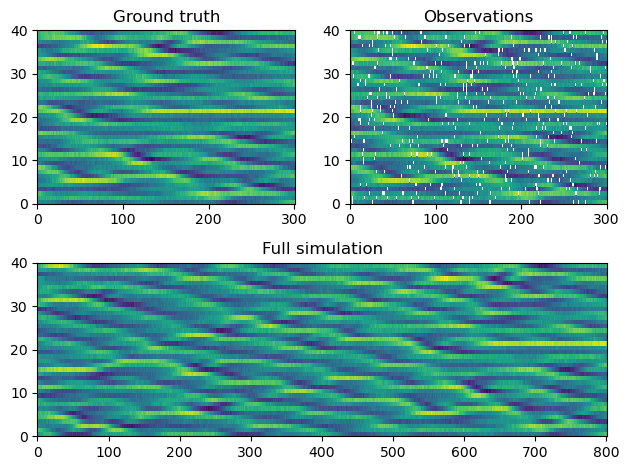

In [59]:
mosaic ="""
AB
CC
"""
fig, daxes = plt.subplot_mosaic(mosaic)
daxes["A"].set_title("Ground truth")
daxes["A"].pcolor(x_true)

daxes["B"].set_title("Observations")
x_obs_preview = x_obs.clone()
x_obs_preview[x_obs_preview == 0] = np.nan
daxes["B"].pcolor(x_obs_preview)

daxes["C"].set_title("Full simulation")
daxes["C"].pcolor(torch.concat([data["x_true"], x_true], dim=-1))
plt.tight_layout()

In [60]:
dataset = AssimilationDataset(x_obs.unsqueeze(0), params, cfg.datamodule.chunk_size)
dataloader = DataLoader(dataset, batch_size=1)

100%|██████████| 148/148 [00:00<00:00, 209.25it/s]


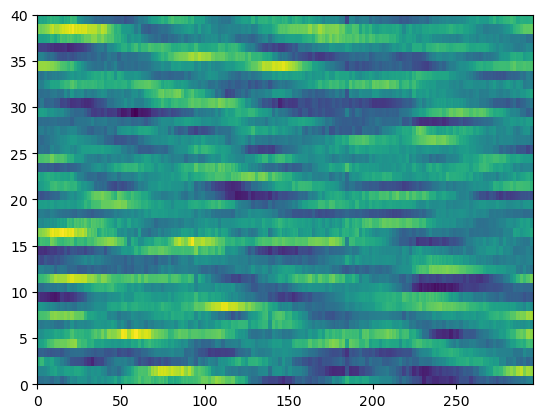

In [61]:
reconstruction = []
for batch in tqdm(dataloader):
    neighbors, _, _, params = batch
    ic_neighbors = neighbors.squeeze()[0]
    ic = assimilator.forward(ic_neighbors)
    rollout = [ic.unsqueeze(0)]
    for i in range(cfg.datamodule.chunk_size - 1):
        x = model.forward(rollout[-1], **params)
        rollout.append(x)
    reconstruction += rollout
reconstruction = torch.stack(reconstruction).squeeze().detach().numpy().T
plt.pcolor(reconstruction)

In [62]:
ground_truth = x_true[..., cfg.datamodule.chunk_size:-cfg.datamodule.chunk_size-1]
observations = x_obs[..., cfg.datamodule.chunk_size:-cfg.datamodule.chunk_size-1]
observations[observations == 0] = np.nan

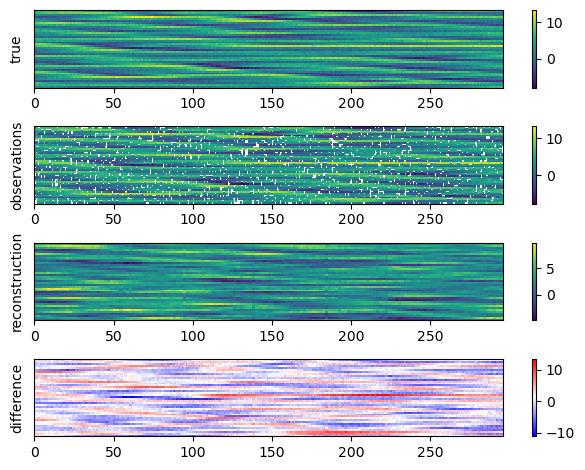

In [63]:
fig, axes = plt.subplots(4, 1, facecolor="w")

axes[0].set_ylabel("true")
img0 = axes[0].pcolor(ground_truth)
plt.colorbar(img0, ax=axes[0])
axes[1].set_ylabel("observations")
img1 = axes[1].pcolor(observations)
plt.colorbar(img1, ax=axes[1])

axes[2].set_ylabel("reconstruction")
img2 = axes[2].pcolor(reconstruction)
plt.colorbar(img2, ax=axes[2])

axes[3].set_ylabel("difference")
img3 = axes[3].pcolor(ground_truth-reconstruction, cmap="bwr")
plt.colorbar(img3, ax=axes[3])

for ax in axes:
    ax.set_yticks([])

plt.tight_layout()